In [1]:
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
from keras import backend as tf
#import pydot as pyd
#import pydotplus
#from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#keras.utils.vis_utils.pydot = pyd



Using TensorFlow backend.


## Function for  Filtering 

In [2]:
from scipy.signal import butter, filtfilt

def butter_bandpass(data,lowcut, highcut, fs, order=5,padlen=150):
    nyq = 0.5 * fs

    low = lowcut / nyq
    high = highcut / nyq
    
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data,padlen=padlen)
    return y

## Generate the Training Data Set 

In [3]:
%load_ext ipycache

C:\Users\aoyem\Anaconda3\envs\ML\lib\site-packages\IPython\config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
C:\Users\aoyem\Anaconda3\envs\ML\lib\site-packages\ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [4]:
%%cache mycache.pkl seismic labels scMin scMax
np.random.seed(13)
nsamp=12000000
thk_min=3    # Minimum thickness measured in samples (dt=1 ms)
thk_mode=5   # modal thickness
thk_max=10   # max thickness
fhcut=80     # high cut for feature vector
flcut=8      # low cut for feature vector
lhcut=300    # high cut for label vector
llcut=3      # low cut for label vector
fs=1000      # sampling freq ---> 1 ms
scMax=5000   # upper limit scale factor
scMin=-5000  # lower limit scale factor  
ntrace=1000  # no sample per trace


## define impedance list
impval=np.int32(np.array(np.linspace(4000,12000,(12000-4000+1))))
imp=np.random.choice(impval,nsamp)


layer_thickness=np.int32(np.random.triangular(thk_min,thk_mode,thk_max,nsamp))

thk_prof=np.cumsum(layer_thickness)
thk_Total=thk_prof[-1]


ref=np.zeros(thk_Total)
##calculate reflectivity series ---> ref=(z2-z1)/(z2+z1)
for ii in range(nsamp-1):
    ref_temp=(imp[ii+1]-imp[ii])/(imp[ii+1]+imp[ii])
    ref[thk_prof[ii]]=ref_temp  

arrlen=len(ref)
ref_rem=arrlen%ntrace

ref_use=arrlen-ref_rem
ref=ref[0:ref_use]
print(ref.shape)

    # Generate the seismic data high resolution pair
seismic=butter_bandpass(ref,flcut, fhcut, fs, order=5)
labels=butter_bandpass(ref,llcut, lhcut, fs, order=5)

[Skipped the cell's code and loaded variables labels, scMax, scMin, seismic from file 'C:\Users\aoyem\mycache.pkl'.]
(66000000,)


## Plot the Data

Text(0.5, 0, 'amp')

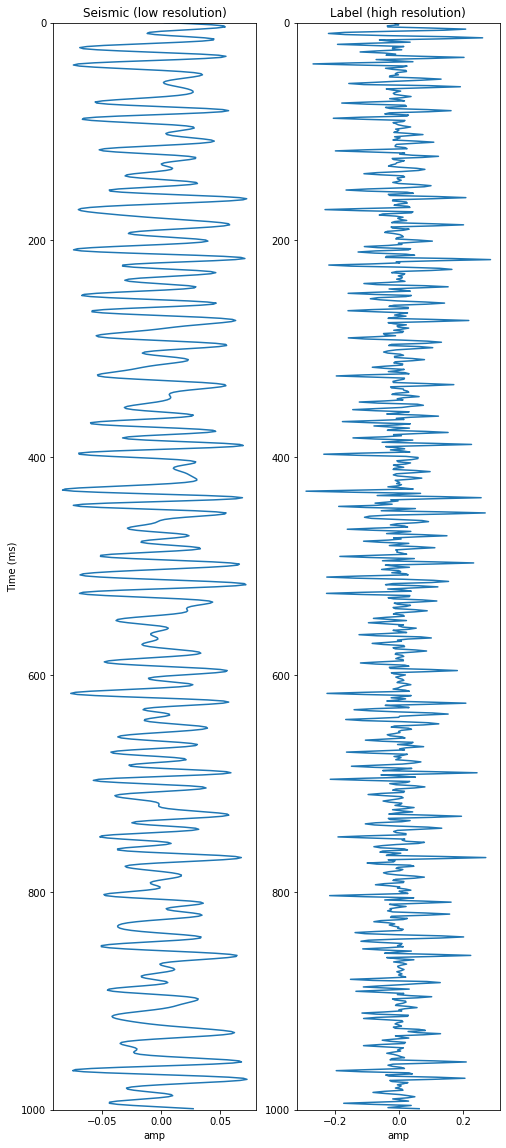

In [5]:
# Plot the data

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(8, 20)) 
ax1.plot(seismic[0:1000], np.array(range(1000)))
ax1.set_title('Seismic (low resolution)')
ax1.set_ylim((0,1000)[::-1])
ax1.set_ylabel('Time (ms)')
ax1.set_xlabel('amp')
ax2.plot(labels[0:1000], np.array(range(1000)))
ax2.set_title('Label (high resolution)')
ax2.set_ylim((0,1000)[::-1])
ax2.set_xlabel('amp')


## Split and Format Data 

In [6]:
## Normalize the data
seismic=scMin +(seismic-np.min(seismic))*(scMax-scMin)/(np.max(seismic)-np.min(seismic))
labels=scMin +(labels-np.min(labels))*(scMax-scMin)/(np.max(labels)-np.min(labels))

seismic=np.reshape(seismic,(-1,1000))
labels=np.reshape(labels,(-1,1000))

x_train, x_test, y_train, y_test = train_test_split(seismic, labels, test_size=0.25, random_state=42)

In [7]:
x_train=np.expand_dims(x_train, axis=-1)
y_train=np.expand_dims(y_train, axis=-1)
x_train=np.expand_dims(x_train, axis=-1)
y_train=np.expand_dims(y_train, axis=-1)

In [8]:
x_train.shape

(49500, 1000, 1, 1)

## Import Ancilliary Functions

In [9]:
sys.path.append(r'E:\PythEnv')
from resnet_model_gpu import resnet_v1, lr_schedule
#from schedule_lr import lr_schedule
#from unet_model import UNet

os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\graphviz2.38\bin'


## Build the ResNet model 

In [10]:
DEPTH=14
batch_size=32
epochs=2000
nrow,ncol,c1,c2=x_train.shape
input_shape=(ncol,c1,c2)

model = resnet_v1(input_shape=input_shape,depth=DEPTH,num_classes=ncol,
                 num_filters=32, nstack=4, kernel_size=(3,1), pool_size=(2,1))
model.summary()
#plot_model(model, to_file='model.png', show_shapes=True)

W1004 14:01:46.038107  7376 deprecation_wrapper.py:119] From C:\Users\aoyem\Anaconda3\envs\ML\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1004 14:01:46.070107  7376 deprecation_wrapper.py:119] From C:\Users\aoyem\Anaconda3\envs\ML\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1004 14:01:46.074107  7376 deprecation_wrapper.py:119] From C:\Users\aoyem\Anaconda3\envs\ML\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000, 1, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1000, 1, 32)  128         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 1000, 1, 32)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 1000, 1, 32)  3104        activation_1[0][0]               
__________________________________________________________________________________________________
activation

## Compile and Run 

In [11]:

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

#model.compile(loss='mean_squared_error',optimizer=Adam(lr=lr_schedule(0)), metrics=["mean_squared_error"])
model.compile(loss='mean_squared_error',optimizer=Adam(lr=lr_schedule(0)), metrics=["mean_squared_error"])

model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_split=0.1,verbose=2,
          shuffle=True,initial_epoch=0,callbacks=callbacks)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


W1004 14:01:46.614114  7376 deprecation_wrapper.py:119] From C:\Users\aoyem\Anaconda3\envs\ML\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Learning rate:  0.01


W1004 14:01:46.995120  7376 deprecation_wrapper.py:119] From C:\Users\aoyem\Anaconda3\envs\ML\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1004 14:01:47.948126  7376 deprecation_wrapper.py:119] From C:\Users\aoyem\Anaconda3\envs\ML\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 44550 samples, validate on 4950 samples
Epoch 1/2000
Learning rate:  0.01
 - 63s - loss: 845697.3069 - mean_squared_error: 845697.2602 - val_loss: 321598.5765 - val_mean_squared_error: 321598.5750
Epoch 2/2000
Learning rate:  0.01
 - 58s - loss: 328260.9692 - mean_squared_error: 328260.9704 - val_loss: 293156.1123 - val_mean_squared_error: 293156.1093
Epoch 3/2000
Learning rate:  0.01
 - 57s - loss: 309341.3107 - mean_squared_error: 309341.3105 - val_loss: 289430.8125 - val_mean_squared_error: 289430.8109
Epoch 4/2000
Learning rate:  0.01
 - 58s - loss: 299351.9543 - mean_squared_error: 299351.9545 - val_loss: 351880.3766 - val_mean_squared_error: 351880.3758
Epoch 5/2000
Learning rate:  0.01
 - 58s - loss: 278339.6920 - mean_squared_error: 278339.6929 - val_loss: 273382.0990 - val_mean_squared_error: 273382.0995
Epoch 6/2000
Learning rate:  0.01
 - 58s - loss: 267032.5259 - mean_squared_error: 267032.5261 - val_loss: 268599.3609 - val_mean_squared_error: 268599.3621
Epoch 7/2

NameError: name 'hms_string' is not defined

In [17]:
model.save_weights('resnet_32_s4_weights.h5')

In [21]:
newmodel = resnet_v1(input_shape=input_shape,depth=DEPTH,num_classes=ncol,
                 num_filters=32, nstack=4, kernel_size=(3,1), pool_size=(2,1))
newmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1000, 1, 1)   0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 1000, 1, 32)  128         input_3[0][0]                    
__________________________________________________________________________________________________
activation_35 (Activation)      (None, 1000, 1, 32)  0           conv2d_43[0][0]                  
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 1000, 1, 32)  3104        activation_35[0][0]              
__________________________________________________________________________________________________
activation

In [19]:
x_test=np.expand_dims(x_test, axis=-1)
x_test=np.expand_dims(x_test, axis=-1)

In [22]:
newmodel.load_weights('resnet_32_s4_weights.h5')

In [24]:
x_pred=newmodel.predict(x_test)

In [37]:
y_test_lb=np.transpose(y_test)
x_pred_sm=np.transpose(np.squeeze(x_pred))

[sz1,sz2]=y_test_lb.shape
samplot=np.random.choice(range(sz2),10)
print(samplot)

[ 6741 10941  5217 12231  2297 11655  1512  7945  7131  9091]


(10,)


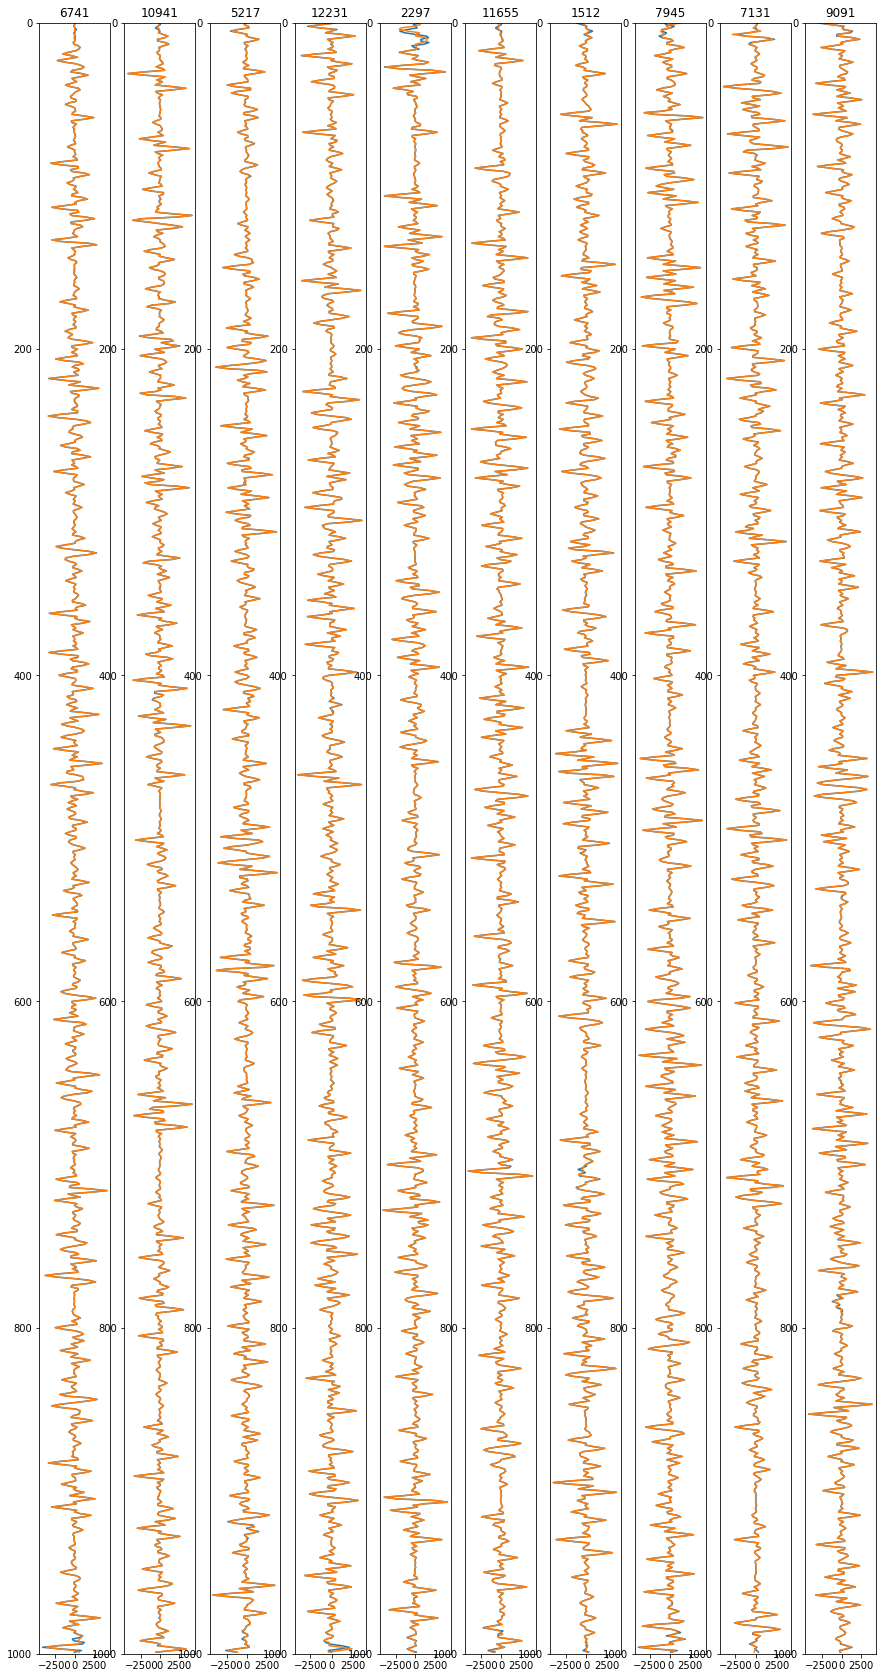

In [49]:
# Plot the data

fig, axs = plt.subplots(nrows=1, ncols=10,figsize=(15, 30)) 
axs=np.ravel(axs)
print(axs.shape)
for aa in range(10):
    xval=samplot[aa]
    axs[aa].plot(y_test_lb[:,xval],np.array(range(1000)))
    axs[aa].plot(x_pred_sm[:,xval],np.array(range(1000)))
    axs[aa].set_title(str(samplot[aa]))
    axs[aa].set_ylim((0,1000)[::-1])
    
